In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import dask 
import pandas as pd
import xrft 
from scipy.interpolate import griddata

from scipy.ndimage import gaussian_filter as gauss


from pyspec import spectrum as spec
from matplotlib.colors import LogNorm

In [2]:
xmon=2

path='/data/pacific/lrenault/SASI/FULL/WRF/'
listm=glob(path+'*DAY.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[-9:])


path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listt=glob(path+'*DAY.nc');listt.sort()
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt)


In [3]:
plt.rcParams['font.size']=15
plt.rcParams['font.sans-serif']='Arial'
plt.rcParams['font.weight']='bold'

In [4]:
vart

<xarray.Dataset>
Dimensions:               (y: 390, x: 300, lev_M: 49, lev_W: 50, time_counter: 274, axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(390, 300), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(390, 300), meta=np.ndarray>
  * lev_M                 (lev_M) float32 1.0 2.0 3.0 4.0 ... 47.0 48.0 49.0
  * lev_W                 (lev_W) float32 1.0 2.0 3.0 4.0 ... 48.0 49.0 50.0
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(30,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2011-11-01T12:00:00 ....
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/28)
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(30, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(30, 2), meta=np.ndarray>
    T2                    (time_counter, y, x) float32 dask.array<chunksize=(30, 390, 300), meta=np.ndarray>
    Q2                    (time_counter, y, x) float32 dask.array<chunksize=(30, 390, 300), meta=np.ndarray>
    RAINCV                (time_counter, y, x) float32 dask.array<chunksize=(30, 390, 300), meta=np.ndarray>
    RAINNCV               (time_counter, y, x) float32 dask.array<chunksize=(30, 390, 300), meta=np.ndarray>
    ...                    ...
    XKHH                  (time_counter, lev_M, y, x) float32 dask.array<chunksize=(30, 49, 390, 300), meta=np.ndarray>
    BN2                   (time_counter, lev_M, y, x) float32 dask.array<chunksize=(30, 49, 390, 300), meta=np.ndarray>
    AKMS                  (time_counter, y, x) float32 dask.array<chunksize=(30, 390, 300), meta=np.ndarray>
    AKHS                  (time_counter, y, x) float32 dask.array<chunksize=(30, 390, 300), meta=np.ndarray>
    EXCH_H                (time_counter, lev_W, y, x) float32 dask.array<chunksize=(30, 50, 390, 300), meta=np.ndarray>
    EXCH_M                (time_counter, lev_W, y, x) float32 dask.array<chunksize=(30, 50, 390, 300), meta=np.ndarray>
Attributes: (12/100)
    name:                            Out/wrf_3D_Y2011M11_DAY
    description:                     wrf M grid variables
    title:                           wrf M grid variables
    Conventions:                     CF-1.6
    timeStamp:                       2020-Jul-29 15:35:10 GMT
    uuid:                            361be864-e040-4674-a332-5e5ed8b8c4e1
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [5]:
varx=['SST','KE','Wind_KE','U_star']
varr=varx[1]


if varr=='SST':

    af = varf.SST[:,:,0:200]
    at = vart.SST[:,:,0:200]
    

elif varr=='KE':

    af = 0.5*(varf.UOCE[:,:,0:200]**2 + varf.VOCE[:,:,0:200]**2)
    at = 0.5*(vart.UOCE[:,:,0:200]**2 + vart.VOCE[:,:,0:200]**2)

elif varr=='Wind_KE':

    af = 0.5*(varf.U10[:,:,0:200]**2 + varf.V10[:,:,0:200]**2)
    at = 0.5*(vart.U10[:,:,0:200]**2 + vart.V10[:,:,0:200]**2)

elif varr=='U_star':
    
    af= varf.UST[:,:,0:200]**2
    at= vart.UST[:,:,0:200]**2

In [6]:

'''
PYSPEC
'''


dxx=0.013*111e3
dyy=0.013*111e3


'''
Isotropic Spec
'''

#SPFULL=np.zeros([af.shape[0],af.shape[1],int(af.shape[2]/2+1)])
#SPSMTH=np.zeros([at.shape[0],at.shape[1],int(at.shape[2]/2+1)])
ISPFULL=np.zeros([af.shape[0],2,89])
ISPSMTH=np.zeros([at.shape[0],2,89])


for ix in range(af.shape[0]):

    spf = spec.TWODimensional_spec(af[ix,:,:],dxx,dyy)
    spt = spec.TWODimensional_spec(at[ix,:,:],dxx,dyy)


    ispf=spec.calc_ispec(spf.k1,spf.k2,spf.spec)
    ispt=spec.calc_ispec(spt.k1,spt.k2,spt.spec)

    ISPFULL[ix,0,:]=ispf[0];
    ISPFULL[ix,1,:]=ispf[1];

    ISPSMTH[ix,0,:]=ispt[0];
    ISPSMTH[ix,1,:]=ispt[1];




findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


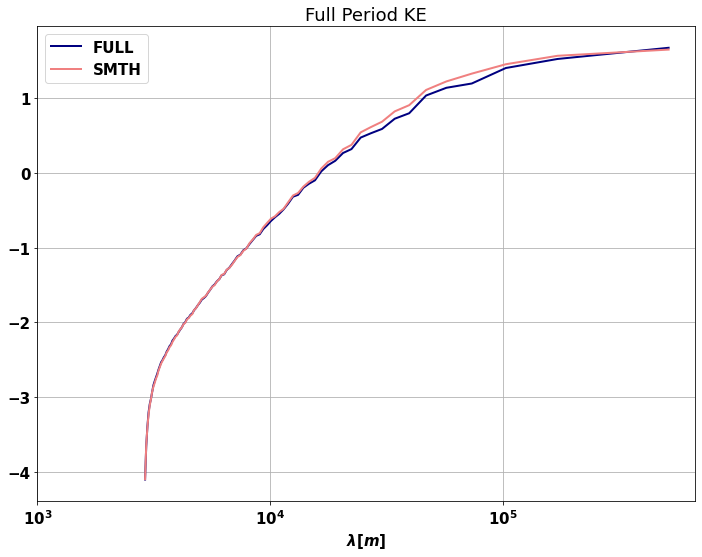

In [7]:
plt.figure(figsize=(10,8))


plt.plot(np.log10(1/np.nanmean(ISPFULL,axis=0)[0]),
        np.log10(np.nanmean(ISPFULL,axis=0)[1][::-1]),label='FULL',linewidth=2,color='navy')

plt.plot(np.log10(1/np.nanmean(ISPSMTH,axis=0)[0]),
        np.log10(np.nanmean(ISPSMTH,axis=0)[1][::-1]),label='SMTH',linewidth=2,color='lightcoral')




plt.legend()

plt.grid()
plt.title('Full Period {0}'.format(varr))

plt.xticks(np.array([3,4,5]),[r'10$^3$',r'10$^4$',r'10$^5$'])
#plt.title(np.datetime_as_string(varf.time_counter[xday].data)[:10])
plt.xlabel(r'$\lambda [m]$')

plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures_xmas/pyspec_mean_{0}.png'.format(varr))
# plt.close()
#

In [8]:
import datetime

t_ind=pd.DatetimeIndex(af.time_centered.compute())
mon_ind=pd.DatetimeIndex(af.time_centered.compute()).month
mes=np.unique(mon_ind)
mes_str=['Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12','Nov/11','Dec/11']
# win_ind=[((mon_ind>=12)&(mon_ind<=2))]
# sum_ind=[((mon_ind>=6)&(mon_ind<=8))]
# # mo_ind



Text(0.5, 0, '$\\lambda [m]$')

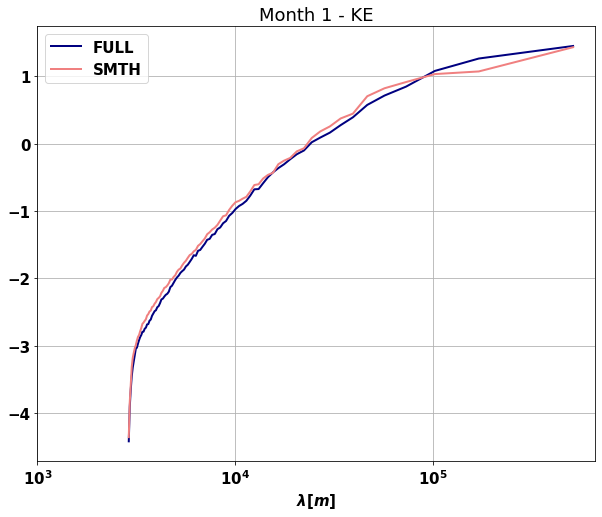

In [12]:
# for ipp in mes:
ipp=1
plt.figure(figsize=(10,8))


plt.plot(np.log10(1/np.nanmean(ISPFULL[mon_ind==ipp,:,:],axis=0)[0]),
        np.log10(np.nanmean(ISPFULL[mon_ind==ipp,:,:],axis=0)[1][::-1]),label='FULL',linewidth=2,color='navy')

plt.plot(np.log10(1/np.nanmean(ISPSMTH[mon_ind==ipp,:,:],axis=0)[0]),
        np.log10(np.nanmean(ISPSMTH[mon_ind==ipp,:,:],axis=0)[1][::-1]),label='SMTH',linewidth=2,color='lightcoral')




plt.legend()

plt.grid()
plt.title('Month {0} - {1}'.format(ipp,varr))

plt.xticks(np.array([3,4,5]),[r'10$^3$',r'10$^4$',r'10$^5$'])
#plt.title(np.datetime_as_string(varf.time_counter[xday].data)[:10])
plt.xlabel(r'$\lambda [m]$')

# plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures_xmas/pyspec_month{0}_var{1}.png'.format(ipp,varr))
# plt.close()

In [34]:
ass=spec.TWODimensional_spec(af[0,:,:].T,dyy,dxx)
isoass=spec.calc_ispec(ass.k1,ass.k2,ass.spec)
isoass[0].shape


(89,)

In [35]:
'TEST----'

'''
PYSPEC
'''

'''
Isotropic Spec
'''

#SPFULL=np.zeros([af.shape[0],af.shape[1],int(af.shape[2]/2+1)])
#SPSMTH=np.zeros([at.shape[0],at.shape[1],int(at.shape[2]/2+1)])
ISPFULL=np.zeros([af.shape[0],2,89])
ISPSMTH=np.zeros([at.shape[0],2,89])


for ix in range(af.shape[0]):

    spf = spec.TWODimensional_spec(af[ix,:,:].T,dxx,dyy)
    spt = spec.TWODimensional_spec(at[ix,:,:].T,dxx,dyy)


    ispf=spec.calc_ispec(spf.k1,spf.k2,spf.spec)
    ispt=spec.calc_ispec(spt.k1,spt.k2,spt.spec)

    ISPFULL[ix,0,:]=ispf[0];
    ISPFULL[ix,1,:]=ispf[1];

    ISPSMTH[ix,0,:]=ispt[0];
    ISPSMTH[ix,1,:]=ispt[1];





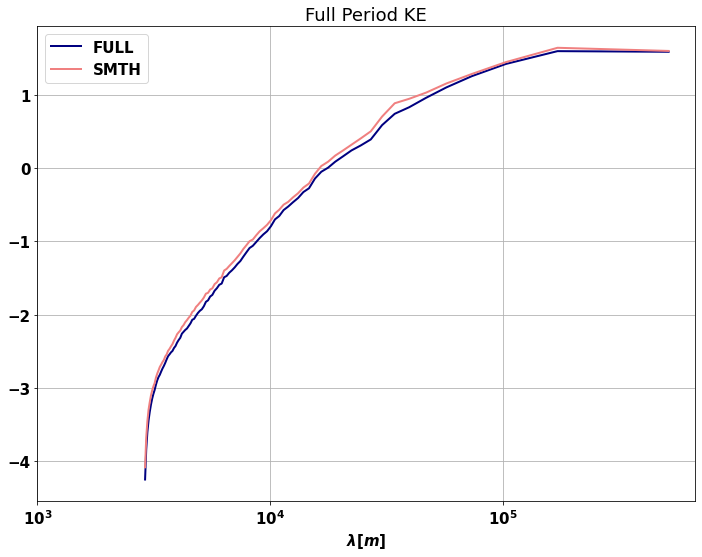

In [36]:
plt.figure(figsize=(10,8))


plt.plot(np.log10(1/np.nanmean(ISPFULL,axis=0)[0]),
        np.log10(np.nanmean(ISPFULL,axis=0)[1][::-1]),label='FULL',linewidth=2,color='navy')

plt.plot(np.log10(1/np.nanmean(ISPSMTH,axis=0)[0]),
        np.log10(np.nanmean(ISPSMTH,axis=0)[1][::-1]),label='SMTH',linewidth=2,color='lightcoral')




plt.legend()

plt.grid()
plt.title('Full Period {0}'.format(varr))

plt.xticks(np.array([3,4,5]),[r'10$^3$',r'10$^4$',r'10$^5$'])
#plt.title(np.datetime_as_string(varf.time_counter[xday].data)[:10])
plt.xlabel(r'$\lambda [m]$')

plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures_xmas/pyspec_mean_{0}.png'.format(varr))
# plt.close()
#

Text(0.5, 0, '$\\lambda [m]$')

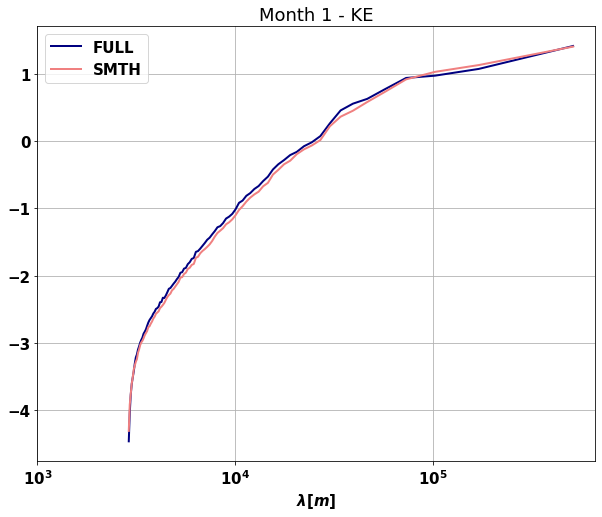

In [37]:
# for ipp in mes:
ipp=1
plt.figure(figsize=(10,8))


plt.plot(np.log10(1/np.nanmean(ISPFULL[mon_ind==ipp,:,:],axis=0)[0]),
        np.log10(np.nanmean(ISPFULL[mon_ind==ipp,:,:],axis=0)[1][::-1]),label='FULL',linewidth=2,color='navy')

plt.plot(np.log10(1/np.nanmean(ISPSMTH[mon_ind==ipp,:,:],axis=0)[0]),
        np.log10(np.nanmean(ISPSMTH[mon_ind==ipp,:,:],axis=0)[1][::-1]),label='SMTH',linewidth=2,color='lightcoral')




plt.legend()

plt.grid()
plt.title('Month {0} - {1}'.format(ipp,varr))

plt.xticks(np.array([3,4,5]),[r'10$^3$',r'10$^4$',r'10$^5$'])
#plt.title(np.datetime_as_string(varf.time_counter[xday].data)[:10])
plt.xlabel(r'$\lambda [m]$')